In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid

% matplotlib inline

In [14]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [ ]:
direct='./nd-twins-0006/faces/'

In [15]:
#read metadata and construct scv for DataLoader
data=pd.read_csv('./image-metadata-2.0.csv')
name_photos=data['filename'].tolist()
folders=[x[:-4] for x in name_photos]
temp_csv=pd.DataFrame({'view':range(len(folders)),'img_a':folders,'img_b':folders})

In [16]:
class TwinsDataloader(Dataset):
    def __init__(self, dataroot, df, transform):
        '''
        dataroot: path to folder with items
        df: pandas dataframe with fields view, id_a, id_b
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        
        def get_img_path(img_id, view):
            
            return self.dataroot+f'{img_id[:5]}/{img_id}__face.jpg'
        
        view, id_a, id_b  = self.df.iloc[index].values
       
        path_a = get_img_path(id_a, view)
        img_a = Image.open(path_a)
        img_a = self.transform(img_a)
        
        return {'img_a': img_a, 'class_a':id_a[:5]}

    def __len__(self):
        return self.df.shape[0]

In [17]:
data_transforms = {
    'train': transforms.Compose([
             transforms.CenterCrop(224),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
           transforms.Resize(224),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [18]:
twins_dataset = TwinsDataloader(direct, temp_csv, data_transforms['train'])
dataset = DataLoader(twins_dataset, batch_size=10,shuffle=True)

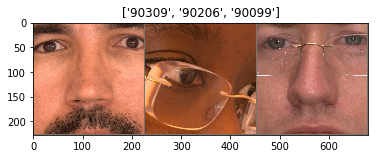

In [24]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
T = next(iter(dataset))
classes=T['class_a']
inputs=T['img_a']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

In [44]:
from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"./model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)

In [26]:

class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

#define model and fix hidden features size
model_flatten = ModelBottom(model)
outputs = model_flatten(inputs)
hid_size=outputs.data.shape[1]

#define n_classes
classes=os.listdir(direct)
n_classes=len(classes)

#define classifier
model_flatten_classifier = nn.Sequential(
                      nn.Linear(hid_size, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

# concatenate conv MobileFaceNet and classifier
class FinModel(nn.Module):
    def __init__(self,flatten_model,classifier_model):
        super(FinModel, self).__init__()
        self.to_flat_model=flatten_model
        self.classifier_model=classifier_model
    def forward(self,x):
        outputs=self.to_flat_model(x)
        outputs=self.classifier_model(outputs)
        return outputs

In [27]:
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

le=LabelEncoder()
lb=LabelBinarizer()
classes=os.listdir(direct)
le.fit(classes)
lb.fit(classes)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [42]:
def train(model, dataloader,optimizer,criterion,device,n_epochs=5):
    model.to(device)
    model.train()
    
    loss_hist=[]
    for epoch in range(n_epochs):
        loss_epoch=0
        for _,T in enumerate(dataloader):
            
            classes=T['class_a']
            inputs=T['img_a']

            inputs=inputs.to(device)
            out=torch.Tensor(lb.transform(classes)).to(device)

            y=model(inputs)

            loss=criterion(y,out)
            
            loss_epoch+=loss.detach().numpy()
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            
            #print(loss_epoch)
        loss_hist.append(loss_epoch)
        plt.plot(loss_hist,label='loss')
        plt.legend()
        plt.show()
    model.eval()
    

In [43]:
fmodel=FinModel(model_flatten,model_flatten_classifier)
optimizer = optim.SGD(fmodel.parameters(),lr=0.01)
criterion=nn.MSELoss()
twins_dataset = TwinsDataloader(direct, temp_csv, data_transforms['train'])
dataset = DataLoader(twins_dataset, batch_size=10,shuffle=True)

train(fmodel,dataset,optimizer,criterion,device,5)

37.02619552612305


FileNotFoundError: [Errno 2] No such file or directory: './nd-twins-0006/faces/90426/90426d15__face.jpg'